# 1. Import libraries
Copied and modified some code from https://zhuanlan.zhihu.com/p/148102950

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from scipy import stats
import math
import matplotlib.pyplot as plt
import seaborn as sns
import os
from itertools import combinations
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.stats import ks_2samp
from optbinning import BinningProcess
import statsmodels.api as sm

# 2. Load data
Data is from https://www.kaggle.com/datasets/kmldas/loan-default-prediction
Create dataframe

In [2]:
df = pd.read_csv('Default_Fin.csv')

# 3. Generate variables
Typically we'd create variables that are ratios where the numerators and denominators are existing variables.

In this example, I created only one variable.

In [3]:
df['Bank Balance/Annual Salary'] = df['Bank Balance'] / df['Annual Salary']

Preview dataframe

In [4]:
df

,Index,Employed,Bank Balance,Annual Salary,Defaulted,Bank Balance/Annual Salary
0,1,1,8754.36,532339.56,0,0.016445
1,2,0,9806.16,145273.56,0,0.067501
2,3,1,12882.60,381205.68,0,0.033794
3,4,1,6351.00,428453.88,0,0.014823
4,5,1,9427.92,461562.00,0,0.020426
...,...,...,...,...,...,...
9995,9996,1,8538.72,635908.56,0,0.013428
9996,9997,1,9095.52,235928.64,0,0.038552
9997,9998,1,10144.92,703633.92,0,0.014418
9998,9999,1,18828.12,440029.32,0,0.042788


Get column names

In [5]:
df.columns

Index(['Index', 'Employed', 'Bank Balance', 'Annual Salary', 'Defaulted',
       'Bank Balance/Annual Salary'],
      dtype='object')

# 5. Zero and null rates

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Index                       10000 non-null  int64  
 1   Employed                    10000 non-null  int64  
 2   Bank Balance                10000 non-null  float64
 3   Annual Salary               10000 non-null  float64
 4   Defaulted                   10000 non-null  int64  
 5   Bank Balance/Annual Salary  10000 non-null  float64
dtypes: float64(3), int64(3)
memory usage: 468.9 KB


## Null rate
None of them are null but this is so we have a template to find the null rate:

In [7]:
na_val_sums = df.isna().sum()
pd.DataFrame({"Column": na_val_sums.index, "Number of Null Values": na_val_sums.values, "Null rate": na_val_sums.values / len(df)})

,Column,Number of Null Values,Null rate
0,Index,0,0.0
1,Employed,0,0.0
2,Bank Balance,0,0.0
3,Annual Salary,0,0.0
4,Defaulted,0,0.0
5,Bank Balance/Annual Salary,0,0.0


## Zero rate

In [8]:
zero_val_sums = (df == 0).sum()
pd.DataFrame({"Column": zero_val_sums.index, "Number of Zero Values": zero_val_sums.values, "Zero rate": zero_val_sums.values / len(df)})

,Column,Number of Zero Values,Zero rate
0,Index,0,0.0000
1,Employed,2944,0.2944
2,Bank Balance,499,0.0499
3,Annual Salary,0,0.0000
4,Defaulted,9667,0.9667
5,Bank Balance/Annual Salary,499,0.0499


Determine missing rates manually (outside of this notebook).

# 6. Auto-binning

This is to look at the upper and lower bounds generated from automated monotonic binning; will still have to manually adjust them later.

Copied some code from this example: https://colab.research.google.com/github/naenumtou/statisticalModel/blob/main/optimumBinning.ipynb#scrollTo=jzQ2qMAw9fUx

## Automatic transformation to ln(%B/%G) (WOE is ln(%G/%B))
Create a dataframe without the ID and separate the target variable

In [9]:
X = df.drop(['Index', 'Defaulted'], axis = 1)
y = df['Defaulted']
# Check X.columns
X.columns

Index(['Employed', 'Bank Balance', 'Annual Salary',
       'Bank Balance/Annual Salary'],
      dtype='object')

Define parameters

More information about other parameters not mentioned in this example: http://gnpalencia.org/optbinning/binning_process.html

In [10]:
# Selection criteria
selectionCriteria = {'iv': {'strategy': 'highest'}}

# Trend features
trendFeature = {'Employed': {'monotonic_trend': 'auto_asc_desc'},
                'Bank Balance': {'monotonic_trend': 'auto_asc_desc'},
                'Annual Salary': {'monotonic_trend': 'auto_asc_desc'}, 
                'Bank Balance/Annual Salary': {'monotonic_trend': 'auto_asc_desc'}}

# Binning process
autobins_bp = BinningProcess(list(X.columns),
                                #categorical_variables = cat_vars,
                                selection_criteria = selectionCriteria,
                                binning_fit_params = trendFeature,
                                n_jobs = -1)

Fitting

In [11]:
autobins_bp.fit(X, y)

BinningProcess(binning_fit_params={'Annual Salary': {'monotonic_trend': 'auto_asc_desc'},
                                   'Bank Balance': {'monotonic_trend': 'auto_asc_desc'},
                                   'Bank Balance/Annual Salary': {'monotonic_trend': 'auto_asc_desc'},
                                   'Employed': {'monotonic_trend': 'auto_asc_desc'}},
               n_jobs=-1, selection_criteria={'iv': {'strategy': 'highest'}},
               variable_names=['Employed', 'Bank Balance', 'Annual Salary',
                               'Bank Balance/Annual Salary'])

Summary table

In [12]:
autobins_bp_summary = autobins_bp.summary()
autobins_bp_summary = autobins_bp_summary.sort_values(by = ['iv'], ascending = False)
autobins_bp_summary

,name,dtype,status,selected,n_bins,iv,js,gini,quality_score
1,Bank Balance,numerical,OPTIMAL,True,6,4.473812,0.398017,0.882768,0.0
3,Bank Balance/Annual Salary,numerical,OPTIMAL,True,9,2.297984,0.219183,0.655237,0.0
2,Annual Salary,numerical,OPTIMAL,True,5,0.037905,0.004726,0.095668,0.000201
0,Employed,numerical,OPTIMAL,True,2,0.036431,0.004544,0.089978,0.083687


Graphs and a dataframe of all variables' bins

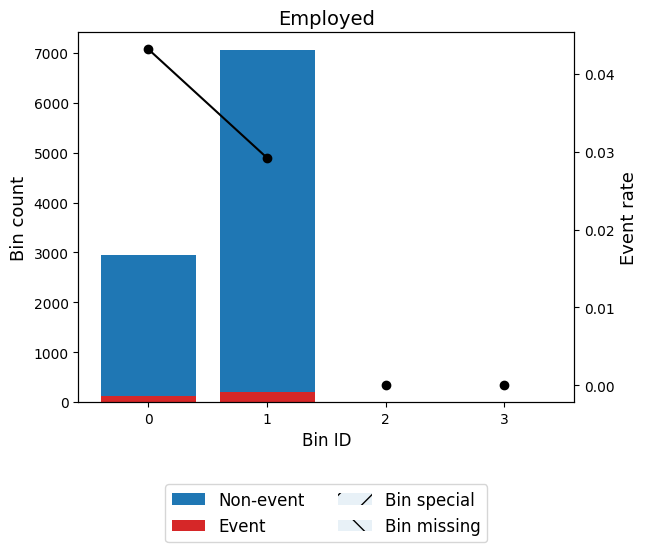

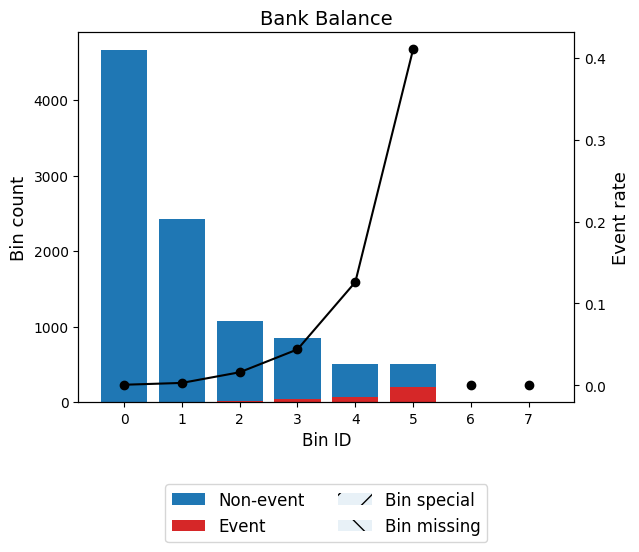

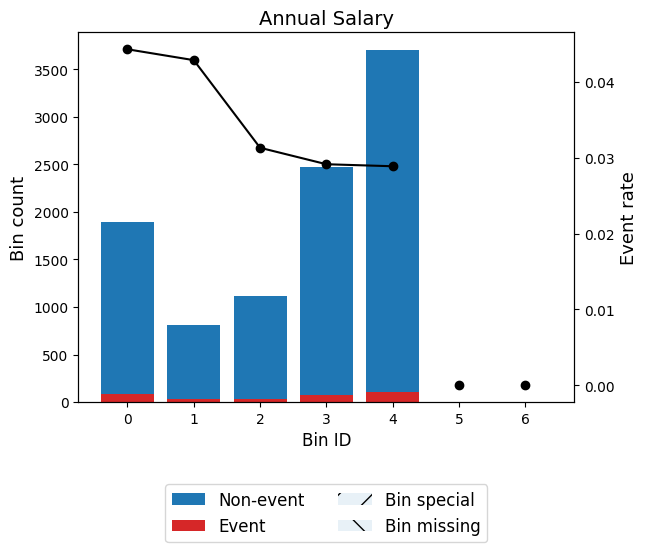

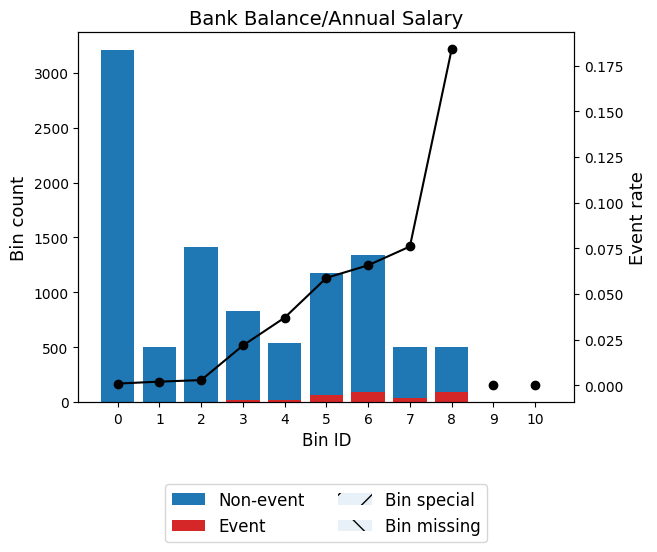

,Factor,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,Employed,"(-inf, 0.50)",2944,0.2944,2817,127,0.043139,-0.26909,0.024212,0.003017
1,Employed,"[0.50, inf)",7056,0.7056,6850,206,0.029195,0.135797,0.012219,0.001526
2,Employed,Special,0,0.0000,0,0,0.000000,0.0,0.000000,0.000000
3,Employed,Missing,0,0.0000,0,0,0.000000,0.0,0.000000,0.000000
Totals,Employed,,10000,1.0000,9667,333,0.033300,,0.036431,0.004544
0,Bank Balance,"(-inf, 9362.40)",4661,0.4661,4658,3,0.000644,3.979398,1.881605,0.147646
1,Bank Balance,"[9362.40, 13188.12)",2424,0.2424,2417,7,0.002888,2.476041,0.567025,0.056973
2,Bank Balance,"[13188.12, 15320.16)",1069,0.1069,1052,17,0.015903,0.756904,0.043728,0.005339
3,Bank Balance,"[15320.16, 17656.44)",844,0.0844,807,37,0.043839,-0.285925,0.007900,0.000984
4,Bank Balance,"[17656.44, 19984.50)",500,0.0500,437,63,0.126000,-1.431532,0.206118,0.023768


In [13]:
# Details of factor
factors = autobins_bp.get_support(names = True)
WOESummary = []

for factor in factors:  
    # Build table
    build = autobins_bp.get_binned_variable(factor)

    # WOE
    WOETable = build.binning_table.build()
    WOETable['Factor'] = factor
    # Drop total row
    #WOETable = WOETable.drop(WOETable.tail(1).index)
    WOESummary.append(WOETable)

    # Plot
    build.binning_table.plot(metric = 'event_rate')

WOESummary = pd.concat(WOESummary, axis = 0)

# Reorder columns
cols = WOESummary.columns
cols = cols[-1:].append(cols[:-1])
WOESummary = WOESummary[cols]
WOESummary

Save as a csv file for future reference. This example doesn't need special encoding, but I'm leaving it here as data in our projects likely will have characters with diacritics.

In [14]:
WOESummary.to_csv('autobins_bp.csv', encoding = 'utf-8-sig', index = False)

Save dataframe as a csv for convenience

In [15]:
df.to_csv('manual_binning_data.csv', encoding = 'utf-8-sig', index = False)

### Re-bucket for short listed factors
Copied some code from the Basel IRB training session and the blog post referenced above. In this particular example, I included all variables because there are so few of them and they all have either very weak or suspicious predictive power. However, IRL we're supposed to short list variables.

Due to auto binning in previous step, the boundary value of auto-buckets might not meaningful. 

Use bounds from manual bins.

In [16]:
Employed_bins = [-math.inf, 0, math.inf]
df['bin_Employed'] = pd.cut(df['Employed'], bins = Employed_bins).astype(str)

BankBalance_bins = [-math.inf, 9362.3, 13188.12, 15320.16, 17656.44, 19984.5, math.inf]
df['bin_BankBalance'] = pd.cut(df['Bank Balance'], bins = BankBalance_bins).astype(str)

BankBalanceToAnnualSalary_bins = [-math.inf, 0.02, 0.03, 0.04, 0.07, 0.09, math.inf]
df['bin_BankBalanceToAnnualSalary'] = pd.cut(df['Bank Balance/Annual Salary'], bins = BankBalanceToAnnualSalary_bins).astype(str)

AnnualSalary_bins = [-math.inf, 267714.36, 344501.77, math.inf]
df['bin_AnnualSalary'] = pd.cut(df['Annual Salary'], bins = AnnualSalary_bins).astype(str)

# 7. WOE and Normscore transformation

## WOE transformation
Create a function to perform WOE transformation based on manual bins

In [17]:
def cal_WOE(df,features,target):
    df_new = df
    for f in features:
        df_woe = df_new.groupby(f).agg({target:['sum','count']})
        df_woe.columns = list(map(''.join, df_woe.columns.values))
        df_woe = df_woe.reset_index()
        df_woe = df_woe.rename(columns = {target+'sum':'bad'})
        df_woe = df_woe.rename(columns = {target+'count':'all'})
        df_woe['good'] = df_woe['all']-df_woe['bad']
        df_woe = df_woe[[f,'good','bad']]
        df_woe['bad_rate'] = df_woe['bad'].mask(df_woe['bad']==0, 1)/df_woe['bad'].sum() # mask 0 to 1 to avoid log(0)
        df_woe['good_rate'] = df_woe['good']/df_woe['good'].sum()
        
        df_woe['woe'] = np.log(df_woe['good_rate'].divide(df_woe['bad_rate'],fill_value=1))
        df_woe.columns = [c if c==f else c+'_'+f for c in list(df_woe.columns.values)]
        df_new = df_new.merge(df_woe,on=f,how='left')
    return df_new

In [18]:
bin_cols = [c for c in df.columns.values if c.startswith('bin_')]
df_woe = cal_WOE(df, bin_cols, 'Defaulted')
woe_cols = [c for c in list(df_woe.columns.values) if 'woe' in c]
df_woe[woe_cols]

,woe_bin_Employed,woe_bin_BankBalance,woe_bin_BankBalanceToAnnualSalary,woe_bin_AnnualSalary
0,0.135797,3.979398,3.553820,0.142631
1,-0.269090,2.476041,-0.688451,-0.287269
2,0.135797,2.476041,-0.415827,0.142631
3,0.135797,3.979398,3.553820,0.142631
4,0.135797,2.476041,0.933653,0.142631
...,...,...,...,...
9995,0.135797,3.979398,3.553820,0.142631
9996,0.135797,3.979398,-0.415827,-0.287269
9997,0.135797,2.476041,3.553820,0.142631
9998,0.135797,-1.431532,-0.688451,0.142631


## Normscore transformation
Create a function to perform Normscore transformation based on manual bins.

In [19]:
def cal_NS(df, features, target, scaling_factor):
    df_new = df
    for f in features:
        df_ns = df_new.groupby(f).agg({target:['sum','count']})
        df_ns.columns = list(map(''.join, df_ns.columns.values))
        df_ns = df_ns.reset_index()
        df_ns = df_ns.rename(columns = {target+'sum':'bad'})
        df_ns = df_ns.rename(columns = {target+'count':'all'})
        df_ns['good'] = df_ns['all']-df_ns['bad']
        df_ns = df_ns[[f,'all','good','bad']]
        df_ns['bad_rate'] = df_ns['bad'].mask(df_ns['bad']==0, 1)/df_ns['bad'].sum() # mask 0 to 1 to avoid log(0)
        df_ns['good_rate'] = df_ns['good']/df_ns['good'].sum()
        
        # 0. Create WOE
        df_ns['woe'] = np.log(df_ns['good_rate'].divide(df_ns['bad_rate'],fill_value=1))
        
        # 1. Create WOE_w
        df_ns['dist'] = df_ns['all'] / len(df)
        df_ns['woe_w'] = df_ns['woe'].dot(df_ns['dist'])
        
        # 2. Create WOE_SD
        df_ns['woe_sd'] = (df_ns['woe'] - df_ns['woe_w']) ** 2
        
        # 3. Create WOE_SD_w
        df_ns['woe_sd_w'] = df_ns['woe_sd'].dot(df_ns['dist'])
        
        # 4. Create NS
        df_ns['ns'] = round(((df_ns['woe'] - df_ns['woe_w'])/(df_ns['woe_sd_w']) ** 0.5) * scaling_factor)
        
        df_ns.columns = [c if c==f else c+'_'+f for c in list(df_ns.columns.values)]
        df_new = df_new.merge(df_ns, on=f, how='left')
    return df_new

We usually use an SD scaling factor of 50, but it can be any number.

In [20]:
bin_cols = [c for c in df.columns.values if c.startswith('bin_')]
df_ns = cal_NS(df, bin_cols, 'Defaulted', 50)
ns_cols = [c for c in list(df_ns.columns.values) if 'ns' in c]
df_ns[ns_cols]

,ns_bin_Employed,ns_bin_BankBalance,ns_bin_BankBalanceToAnnualSalary,ns_bin_AnnualSalary
0,32.0,41.0,57.0,33.0
1,-77.0,5.0,-51.0,-81.0
2,32.0,5.0,-44.0,33.0
3,32.0,41.0,57.0,33.0
4,32.0,5.0,-10.0,33.0
...,...,...,...,...
9995,32.0,41.0,57.0,33.0
9996,32.0,41.0,-44.0,-81.0
9997,32.0,5.0,57.0,33.0
9998,32.0,-90.0,-51.0,33.0


# 9. Collinearity
Check for collinearity and drop one of two collinear ($R^{2}$ ≥ 0.8) variables

## WOE

In [21]:
woe_dfCorr = df_woe.filter(regex='^woe_bin_',axis=1)
woe_corr = woe_dfCorr.corr()
woe_corr.style.background_gradient(cmap='coolwarm')
# 'RdBu_r' & 'BrBG' are other good diverging colormaps

,woe_bin_Employed,woe_bin_BankBalance,woe_bin_BankBalanceToAnnualSalary,woe_bin_AnnualSalary
woe_bin_Employed,1.000000,0.184917,0.527506,0.840033
woe_bin_BankBalance,0.184917,1.000000,0.688892,0.154141
woe_bin_BankBalanceToAnnualSalary,0.527506,0.688892,1.000000,0.534948
woe_bin_AnnualSalary,0.840033,0.154141,0.534948,1.000000


## Normscore

In [22]:
ns_dfCorr = df_ns.filter(regex='^ns_bin_',axis=1)
ns_corr = ns_dfCorr.corr()
ns_corr.style.background_gradient(cmap='coolwarm')

,ns_bin_Employed,ns_bin_BankBalance,ns_bin_BankBalanceToAnnualSalary,ns_bin_AnnualSalary
ns_bin_Employed,1.000000,0.184792,0.527113,0.839868
ns_bin_BankBalance,0.184792,1.000000,0.687987,0.154014
ns_bin_BankBalanceToAnnualSalary,0.527113,0.687987,1.000000,0.534375
ns_bin_AnnualSalary,0.839868,0.154014,0.534375,1.000000


In this example, drop Annual Salary
# 10. Shortlist

In [23]:
woe_dfShortlist = df_woe[woe_cols].drop(['woe_bin_AnnualSalary'], axis = 1)
woe_dfShortlist

,woe_bin_Employed,woe_bin_BankBalance,woe_bin_BankBalanceToAnnualSalary
0,0.135797,3.979398,3.553820
1,-0.269090,2.476041,-0.688451
2,0.135797,2.476041,-0.415827
3,0.135797,3.979398,3.553820
4,0.135797,2.476041,0.933653
...,...,...,...
9995,0.135797,3.979398,3.553820
9996,0.135797,3.979398,-0.415827
9997,0.135797,2.476041,3.553820
9998,0.135797,-1.431532,-0.688451


In [24]:
ns_dfShortlist = df_ns[ns_cols].drop(['ns_bin_AnnualSalary'], axis = 1)
ns_dfShortlist

,ns_bin_Employed,ns_bin_BankBalance,ns_bin_BankBalanceToAnnualSalary
0,32.0,41.0,57.0
1,-77.0,5.0,-51.0
2,32.0,5.0,-44.0
3,32.0,41.0,57.0
4,32.0,5.0,-10.0
...,...,...,...
9995,32.0,41.0,57.0
9996,32.0,41.0,-44.0
9997,32.0,5.0,57.0
9998,32.0,-90.0,-51.0


# 11. Split train and test
We usually split the data into 80% train and 20% test

Split WOE into train and test

In [25]:
X_woe_train, X_woe_test, y_woe_train, y_woe_test = train_test_split(woe_dfShortlist, df_woe['Defaulted'], test_size = 0.2, random_state = 172008)

Split Normscore into train and test

In [26]:
X_ns_train, X_ns_test, y_ns_train, y_ns_test = train_test_split(ns_dfShortlist, df_ns['Defaulted'], test_size = 0.2, random_state = 172008)

# 12. Logistic regression
Create a function to summarise backward elimination results

In [27]:
def backwardElimination(data, target,significance_level = 0.05):
    features = data.columns.tolist()
    while(len(features)>0):
        features_with_constant = sm.add_constant(data[features])
        p_values = sm.Logit(target, features_with_constant).fit().pvalues[1:]

        max_p_value = p_values.max()
        if(max_p_value >= significance_level):
            excluded_feature = p_values.idxmax()
            features.remove(excluded_feature)
#             print('Add  {:30} with p-value {:.6}'.format(best_feature, max_p_value))
        else:
            break
    features_with_constant_sum = sm.add_constant(data[features])
    logit = sm.Logit(target, features_with_constant_sum).fit()
    result_summary= logit.summary()
    return logit, result_summary, features

For this example, we're only doing NS

In [28]:
summary_ns = backwardElimination(X_ns_train, y_ns_train, 0.1)
summary_ns

Optimization terminated successfully.
         Current function value: 0.082400
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.082487
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.082487
         Iterations 10


(<statsmodels.discrete.discrete_model.BinaryResultsWrapper at 0x1b6a22a6c70>,
 <class 'statsmodels.iolib.summary.Summary'>
 """
                            Logit Regression Results                           
 Dep. Variable:              Defaulted   No. Observations:                 8000
 Model:                          Logit   Df Residuals:                     7997
 Method:                           MLE   Df Model:                            2
 Date:                Wed, 24 May 2023   Pseudo R-squ.:                  0.4409
 Time:                        12:09:36   Log-Likelihood:                -659.90
 converged:                       True   LL-Null:                       -1180.4
 Covariance Type:            nonrobust   LLR p-value:                9.223e-227
                          coef    std err          z      P>|z|      [0.025      0.975]
 --------------------------------------------------------------------------------------
 const                 -5.8130      0.208    -27.954    

All coefficients are supposed to be negative.

If there's a positive one, there's something wrong with the data but for this example I'm not going to check. Usually drop it without checking.

Run another one excluding ns_bin_Employed.

In [29]:
ns_dfShortlist = df_ns['ns_bin_BankBalance'].to_frame()
X_ns_train, X_ns_test, y_ns_train, y_ns_test = train_test_split(ns_dfShortlist, df_ns['Defaulted'], test_size = 0.2, random_state = 172008)

In [30]:
type(ns_dfShortlist)

pandas.core.frame.DataFrame

In [31]:
summary2_ns = backwardElimination(X_ns_train, y_ns_train, 0.1)
summary2_ns

Optimization terminated successfully.
         Current function value: 0.083167
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.083167
         Iterations 10


(<statsmodels.discrete.discrete_model.BinaryResultsWrapper at 0x1b6a22a68b0>,
 <class 'statsmodels.iolib.summary.Summary'>
 """
                            Logit Regression Results                           
 Dep. Variable:              Defaulted   No. Observations:                 8000
 Model:                          Logit   Df Residuals:                     7998
 Method:                           MLE   Df Model:                            1
 Date:                Wed, 24 May 2023   Pseudo R-squ.:                  0.4363
 Time:                        12:09:54   Log-Likelihood:                -665.34
 converged:                       True   LL-Null:                       -1180.4
 Covariance Type:            nonrobust   LLR p-value:                5.278e-226
                          coef    std err          z      P>|z|      [0.025      0.975]
 --------------------------------------------------------------------------------------
 const                 -5.7564      0.204    -28.222    

# 13. Model validation

In [32]:
X_ns_train=X_ns_train[['ns_bin_BankBalance']]
X_ns_test=X_ns_test[['ns_bin_BankBalance']]

In [33]:
#instantiate model and train
logit_model = LogisticRegression(penalty='none',fit_intercept = True, C = 1e9)
logit_model.fit(X_ns_train, y_ns_train)


# make predictions for test set
y_ns_train_predict = logit_model.predict(X_ns_train)
y_ns_pred = logit_model.predict(X_ns_test)
accuracy_train_logit = accuracy_score(y_ns_train, y_ns_train_predict)
accuracy_test_logit = accuracy_score(y_ns_test, y_ns_pred)

y_ns_pred_prob_train = logit_model.predict_proba(X_ns_train)[:, 1]
y_ns_pred_prob_test = logit_model.predict_proba(X_ns_test)[:, 1]

auc_roc_score_train = metrics.roc_auc_score(y_ns_train, y_ns_pred_prob_train)
auc_roc_score_test = metrics.roc_auc_score(y_ns_test, y_ns_pred_prob_test)

gini_train_logit = 2*auc_roc_score_train - 1
gini_test_logit = 2*auc_roc_score_test - 1
print("Logistic Regression")
print("Gini Train: %.2f%%" % (gini_train_logit  * 100.0))
print("Gini Test: %.2f%%" % (gini_test_logit * 100.0))
print("Accuracy Train: %.2f%%" % (accuracy_train_logit  * 100.0))
print("Accuracy Test: %.2f%%" % (accuracy_test_logit * 100.0))

Logistic Regression
Gini Train: 88.79%
Gini Test: 86.06%
Accuracy Train: 96.62%
Accuracy Test: 96.85%


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


In [37]:
X_ns_train1=sm.add_constant(X_ns_train)
log_reg = sm.Logit(y_ns_train, X_ns_train1).fit()
log_reg_summary = log_reg.summary()
log_reg_summary

Optimization terminated successfully.
         Current function value: 0.083167
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Defaulted   No. Observations:                 8000
Model:                          Logit   Df Residuals:                     7998
Method:                           MLE   Df Model:                            1
Date:                Wed, 24 May 2023   Pseudo R-squ.:                  0.4363
Time:                        13:18:03   Log-Likelihood:                -665.34
converged:                       True   LL-Null:                       -1180.4
Covariance Type:            nonrobust   LLR p-value:                5.278e-226
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -5.7564      0.204    -28.222      0.000      -6.156      -5.357
ns_bin_BankBalance    -0.0425      0.002    -21.917      0.000      -0.046      -0.039
======================================================================================
"""

Copy the results into Excel and scale there.

# 14. Generate scorecard in Excel then map scores

In an Excel file